In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import copy

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
data_dir = "../mel_data"
model_dir = "../Models"
csv_dir = "../Speech_CSV"

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cpu")
print(class_names)

['a', 'd', 'f', 'h', 'n', 'sa', 'su']


In [5]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

tensor([4, 5, 4, 2, 5, 6, 4, 4, 5, 5, 5, 1, 4, 4, 2, 6])


In [7]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

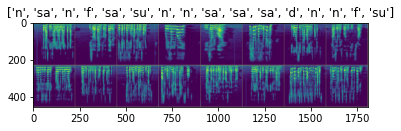

In [8]:
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [10]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, d in enumerate(tqdm(dataloaders[phase])):
                inputs = d[0].to(device)
                labels = d[1].to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_loss_gph.append(epoch_loss)
              train_acc_gph.append(epoch_acc)
            if phase == 'val':
              val_loss_gph.append(epoch_loss)
              val_acc_gph.append(epoch_acc)
            
            plot(val_loss_gph,train_loss_gph, "Loss")
            plot(val_acc_gph,train_acc_gph, "Accuracy")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, model_dir+"/"+model_name+".h5")
                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model = torch.load('../Models/googlenet.h5')

Using cache found in C:\Users\asus/.cache\torch\hub\pytorch_vision_v0.10.0


In [13]:
num_ftrs = model.fc.in_features

In [14]:
print("Number of features: "+str(num_ftrs))
# Here the size of each output sample is set to 2.

Number of features: 1024


In [15]:
# model.fc = nn.Linear(num_ftrs, num_classes) ## for wideresnet-50-2
model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg11
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20, model_name = "googlenet")


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch 1/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.8362 Acc: 0.6977


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 1.3262 Acc: 0.6132
==>Model Saved

Epoch 2/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.5536 Acc: 0.8120


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.5266 Acc: 0.8138
==>Model Saved

Epoch 3/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.3775 Acc: 0.8720


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.6420 Acc: 0.7908

Epoch 4/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.1808 Acc: 0.9360


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 2.4051 Acc: 0.5014

Epoch 5/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.1829 Acc: 0.9449


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.7672 Acc: 0.7851

Epoch 6/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.2135 Acc: 0.9263


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.4201 Acc: 0.8510
==>Model Saved

Epoch 7/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.2208 Acc: 0.9222


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.5169 Acc: 0.8338

Epoch 8/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.1371 Acc: 0.9579


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.4905 Acc: 0.8539
==>Model Saved

Epoch 9/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.1511 Acc: 0.9514


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.4363 Acc: 0.8481

Epoch 10/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0953 Acc: 0.9660


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.4528 Acc: 0.8911
==>Model Saved

Epoch 11/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0328 Acc: 0.9943


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1787 Acc: 0.9599
==>Model Saved

Epoch 12/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0195 Acc: 0.9959


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1439 Acc: 0.9713
==>Model Saved

Epoch 13/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0100 Acc: 0.9992


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1959 Acc: 0.9656

Epoch 14/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.9968


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1960 Acc: 0.9742
==>Model Saved

Epoch 15/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0077 Acc: 0.9984


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1966 Acc: 0.9685

Epoch 16/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0091 Acc: 0.9976


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1658 Acc: 0.9742
==>Model Saved

Epoch 17/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0082 Acc: 0.9984


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1426 Acc: 0.9771
==>Model Saved

Epoch 18/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0065 Acc: 0.9992


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1662 Acc: 0.9713

Epoch 19/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0041 Acc: 1.0000


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

val Loss: 0.1625 Acc: 0.9742

Epoch 20/20
----------


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

train Loss: 0.0069 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:41<00:00,  1.87s/it]


val Loss: 0.1458 Acc: 0.9771
==>Model Saved

Training complete in 166m 49s
Best val Acc: 0.977077


In [18]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '../Models/GoogleNet.pth')

In [20]:
checkpoint = torch.load('../Models/GoogleNet.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
# load the criterion
criterion = checkpoint['loss']
print('Trained model loss function loaded...')

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...


In [19]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
testloader=torch.utils.data.DataLoader(image_datasets['val'],batch_size=1)


Getting the Probability Distribution


In [20]:
model=model.eval()
correct = 0
total = 0
import csv
import numpy as np
#f = open(data_dir+"/vgg11.csv",'w+',newline = '')
f = open(csv_dir+"/googlenet.csv",'w+',newline = '')
writer = csv.writer(f)

In [21]:
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for data in testloader:
          images, labels = data
          #labels=labels.cuda()
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Accuracy = ",100*correct/total)

Accuracy =  97.70773638968481


In [22]:
for i in range(len(testloader)):
  writer.writerow(temp_array[i].tolist())
f.close()

87.10601719197707
97.70773638968481